In [1]:
import os 
import pathlib
import pickle as pkl
#import pyarrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import itertools
import re
#import sklearn
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, label_binarize, LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
def load_prep_features(path):
    """ Load preprocessed data """
    with open(path, 'rb') as file:
        X, y = pkl.load(file)
    return X, y

In [ ]:
def split_features(data_path):
    """ """ 
    X, y = load_prep_features(data_path) # load prepped data
    lb = LabelBinarizer()                # define label binarizer (y)
    y = lb.fit_transform(y)              # fit and transform (y)
    y_classes = lb.classes_              # extract classes (y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=104, test_size=0.20, shuffle=True, stratify=y)
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = split_features("../data/preprocessed/features.pkl")

Features: 
- binary features: 
    - 'cha': chamber (H: House or S: Senate)
    - 'lobbied': whether the bill was lobbied on (lobby or no_lobby)

- categorical features: 
    - 'state': the state the bill is from ()

'state', 'ncsl_metatopics', 'cha', 'lobbied', 'neut_blocks',
       'opp_blocks', 'sup_blocks', 'neut_counts', 'opp_counts', 'sup_counts',
       'chamber', 'dem', 'rep', 'majority', 'minority', 'dem_mean', 'rep_mean',
       'diffs', 'distance'

In [8]:
X_train

,state,ncsl_metatopics,cha,lobbied,neut_blocks,opp_blocks,sup_blocks,neut_counts,opp_counts,sup_counts,chamber,dem,rep,majority,minority,dem_mean,rep_mean,diffs,distance
6954,IA,[M],S,lobby,"[149, 190, 203, 209, 230, 26, 262, 45, 5, 51, 58]","[203, 230, 45, 58]","[130, 190, 230, 45, 58]","[2, 14, 4, 1, 2, 4, 1, 4, 4, 1, 2]","[1, 2, 1, 4]","[1, 9, 2, 1, 2]",-0.662,-0.912,0.693,-0.912,0.693,-0.929679,0.692863,1.605,0.915324
54393,MA,[M],H,no_lobby,N,N,N,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34597,MA,[M],S,no_lobby,N,N,N,0,0,0,-1.078,-1.120,0.141,-1.120,0.141,-1.107051,0.128131,1.261,0.421539
122986,NJ,[M],S,no_lobby,N,N,N,0,0,0,-0.945,-1.054,0.089,-1.054,0.089,-1.052374,0.106960,1.143,0.641965
37601,MA,[M],H,no_lobby,N,N,N,0,0,0,-1.086,-1.132,0.158,-1.132,0.158,-1.168766,0.173895,1.290,0.577604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97766,NJ,[M],H,no_lobby,N,N,N,0,0,0,-1.041,-1.136,0.053,-1.136,0.053,-1.105758,0.114509,1.189,0.663905
80672,NE,[ncsl_metatopic__civil_and_criminal_justice],S,lobby,"[11, 122, 18, 28, 89]","[15, 18, 28]",[11],"[1, 2, 1, 1, 2]","[2, 1, 1]",[5],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15540,IA,[M],H,lobby,"[142, 51, 79]",N,[51],"[9, 1, 1]",0,[5],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142003,RI,[ncsl_metatopic__transportation],S,no_lobby,N,N,N,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
ct = ColumnTransformer(
    [("categorical_prep", OneHotEncoder(sparse_output=False), ["state"]), 
     ("ordinal_prep", OrdinalEncoder(categories=[[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]], dtype="int32"), ["bill_year"]),
     ("binary_prep", OneHotEncoder(sparse_output=False, drop="if_binary"), ["lobbied"]),
    # ("multi_cat_prep", CountVectorizer(analyzer=lambda lst: lst), "ncsl_metatopics")
    ]
)

In [97]:
X_test_tr=ct.fit_transform(X_test[[
    "state", "bill_year", "lobbied", "ncsl_metatopics"]])#, 'neut_blocks', 'opp_blocks', 'sup_blocks']])
X_test_tr

array([[ 0.,  0.,  1., ...,  0., 11.,  0.],
       [ 0.,  1.,  0., ...,  0., 13.,  1.],
       [ 0.,  0.,  0., ...,  0., 11.,  1.],
       ...,
       [ 0.,  1.,  0., ...,  0., 13.,  0.],
       [ 0.,  0.,  0., ...,  0.,  7.,  0.],
       [ 0.,  0.,  0., ...,  0.,  9.,  0.]], shape=(32151, 8))

In [98]:
X_train_tr=ct.fit_transform(X_train[[
    "state", "bill_year", "lobbied"]])#, 'neut_blocks', 'opp_blocks', 'sup_blocks']])
X_train_tr

array([[ 1.,  0.,  0., ...,  0.,  3.,  0.],
       [ 0.,  1.,  0., ...,  0., 13.,  1.],
       [ 0.,  1.,  0., ...,  0.,  7.,  1.],
       ...,
       [ 1.,  0.,  0., ...,  0., 13.,  0.],
       [ 0.,  0.,  0., ...,  0., 12.,  1.],
       [ 0.,  1.,  0., ...,  0., 11.,  0.]], shape=(128602, 8))

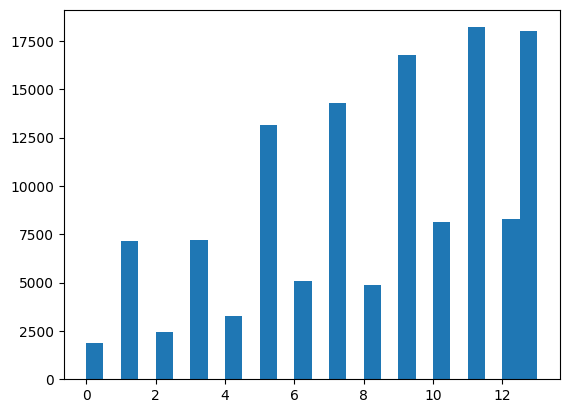

In [ ]:
#hist of bill year
plt.hist(X_train_tr[0:, 6], bins=26)
plt.show()

In [71]:
LR = LogisticRegression()

In [73]:
LR.fit(X_train_tr, y_train)

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:


#block features: 
enc_blocks, names_blocks = encode_blocks(X_df, col_blocks=["neut_blocks", "opp_blocks", "sup_blocks"])

X_n = transform_block_counts(X_df, blocks_col="neut_blocks", 
                                               counts_col="neut_counts", fitted_encoder=enc_blocks)
X_s = transform_block_counts(X_df, blocks_col="sup_blocks", 
                                               counts_col="sup_counts", fitted_encoder=enc_blocks)
X_o = transform_block_counts(X_df, blocks_col="opp_blocks", 
                                               counts_col="opp_counts", fitted_encoder=enc_blocks)                                               


In [31]:
np.ndarray([[1,1,2],[[1,1],[2,2]]])

TypeError: 'list' object cannot be interpreted as an integer

In [77]:
fitted_encoder = enc_blocks
X_df = X_test.copy()
blocks_col = "neut_blocks"
counts_col = "neut_counts"
X_blocks = fitted_encoder.transform(X_df[blocks_col]).toarray()
X_counts = X_df[counts_col]

for i, (row_blocks, row_counts) in enumerate(zip(X_blocks, X_counts), start=0):
    if type(row_counts) == list:
        inds = np.asarray(row_blocks==1).nonzero()[0]
        for j, (index, count) in enumerate(zip(inds, row_counts), start=0):
            row_blocks[index] = count

In [ ]:
def transform_block_counts(X_df, blocks_col:str, counts_col:str, fitted_encoder):
    """ 
    Uses a fitted encoder to transform block features, then the respective count data is used inputted
    to to features. It returns the transformed feature. It takes the df with the features (X_df), the
    column name with block assignments (blocks_col), the column name with the count data, and the 
    fitted encoder.  
    """
    X_blocks = fitted_encoder.transform(X_df[blocks_col]).toarray()
    X_counts = X_df[counts_col]
    
    for i, (row_blocks, row_counts) in enumerate(zip(X_blocks, X_counts), start=0):
        if type(row_counts) == list:
            inds = np.asarray(row_blocks==1).nonzero()[0]
            for j, (index, count) in enumerate(zip(inds, row_counts), start=0):
                row_blocks[index] = count  
    return X_blocks

In [ ]:
def encode_blocks(X_df, col_blocks:list):
    """ 
    Fits a sklearn Countvectoriser to the blocks that have positions on the bills. Takes the df with
    the features (X_df) and the names of the columns with blocks as a list (col_blocks). Returns the
    fitted encoder and the feature names
    """
    enc_blocks = CountVectorizer(analyzer=lambda lst: lst)
    enc_blocks.fit(np.concatenate((X_df[col_blocks[0]].to_numpy(), 
                                   X_df[col_blocks[1]].to_numpy(), 
                                   X_df[col_blocks[2]].to_numpy())))
    names_blocks = enc_blocks.get_feature_names_out()
    return enc_blocks, names_blocks

In [ ]:
def ordinal_years_encoder(X_df, X_feature, years_list):
    """ 
    Uses sklearns OrdinalEncoder to encode years as ordered categorical variables. Takes the df
    with the feature (X_df), the column names (X_feature) and an ordered list of the categories
    as a list. Returns the categories (names) and transformed features. 
    """
    enc = OrdinalEncoder(categories=years_list, dtype="int32")
    X_transformed = enc.fit_transform(X_df[[X_features]].to_numpy())
    names = enc.categories_
    return X_transformed, names

In [ ]:
def categroical_encoder(X_df, X_feature:str, enc_type:str):
    """
    Encoded categorical feature. Feature is given by a dataframe (X_df) and a given column 
    name (X_feature). The type of encodding is given by a string (enc_type). Either 'onehot' or
    'multi' (resulting in using sklearn OneHotEncoder or CountVectoriser respectively). The 
    function returns the transformed features. 
        onehot is used for 'state' and 'lobbied'
        multi is used for 'ncsl_topics', 'ncsl_metatopics', 
    """
    assert enc_type in ["onehot", "multi"], "enc_type should be either 'onehot' or 'multi'"
    if enc_type == "onehot":
        enc = OneHotEncoder(sparse_output=False)
        X_transformed = enc.fit_transform(X_df[[X_feature]].to_numpy())
        names = enc.get_feature_names_out([X_feature])
    elif enc_type == "multi":
        enc = CountVectorizer(analyzer=lambda lst: lst)
        X_transformed = enc.fit_transform(X_df[X_feature]).toarray()
        names = enc.get_feature_names_out()     
    return X_transformed, names